# Entrenamiento de Score Net para VE

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import json
import sys, os
sys.path.insert(0, os.path.abspath("diffusion"))
sys.path.insert(0, os.path.abspath("utils"))
sys.path.insert(0, os.path.abspath("models"))
sys.path.insert(0, os.path.abspath("samplers"))


from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional
import torchvision.transforms as transforms

from torch.optim import Adam

from diffusion.schedules import LinearSchedule, CosineSchedule, NoiseSchedule
from diffusion.sde       import VESDE, VPSDE, SubVPSDE


from diffusion_utilities import (
    plot_image_grid,
    plot_image_evolution,
    animation_images,
)

import euler_maruyama, predictor_corrector, probability_flow_ode, exponential_integrator
# from score_resnet_model import ScoreResNet
from models import score_net
import tqdm


# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available and will be used.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU instead.")


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))
# Now you can use the 'device' variable in your PyTorch code:
# For example:
# model.to(device)  # Moves your model to the selected device
# data = data.to(device) # Moves your data to the selected device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available and will be used.
Number of threads: 6


In [10]:
# --- Configuraciones ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 32
IMG_CHANNELS = 3
BATCH_SIZE = 128 # Ajustar según memoria de GPU
LEARNING_RATE = 2e-4
N_EPOCHS = 200 # Número de épocas de entrenamiento
T_END = 1.0 # Tiempo final para la SDE
SDE_TYPE = 'VE' # 'VP' o 'VE' o 'SubVP'
SCHEDULE_TYPE = 'No' # 'Linear' o 'Cosine'
BETA_MIN = 0.1
BETA_MAX = 20.0
SIGMA_MIN = 0.01 # Para VE SDE
SIGMA_MAX = 50.0  # Para VE SDE
SIGMA = 50.0
CHECKPOINT_DIR = './checkpoints'
CHECKPOINT_FREQ = 10 # Guardar checkpoint cada N épocas
EPS_LOSS = 1e-5 # Epsilon para muestrear t en la loss_function
S = 0.008 # Para CosineSchedule

In [ ]:

# --- Dataset ---
# Normalización a [-1, 1] es común para estos modelos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=min(4, os.cpu_count()), pin_memory=True)

# --- Inicialización ---

if SCHEDULE_TYPE == 'Linear':
    schedule = LinearSchedule(beta_min=BETA_MIN, beta_max=BETA_MAX, T=T_END)
elif SCHEDULE_TYPE == 'Cosine':
    schedule = CosineSchedule(T=T_END, s=S)
elif SCHEDULE_TYPE == 'No':
    pass
else:
    raise ValueError(f"Schedule type {SCHEDULE_TYPE} no soportado.")

# Crear SDE
if SDE_TYPE == 'VP':
    sde = VPSDE(schedule=schedule)
elif SDE_TYPE == 'VE':
    sde = VESDE(sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, sigma=SIGMA)
elif SDE_TYPE == 'SubVP':
    sde = SubVPSDE(schedule=schedule)
else:
    raise ValueError(f"SDE type {SDE_TYPE} no soportado.")

# Crear Modelo ScoreNet
score_model = score_net.ScoreNet(
    marginal_prob_std=partial(sde.sigma_t),
    input_channels=IMG_CHANNELS,
    output_channels=IMG_CHANNELS,
    base_channels=128,
    channel_mults=(1, 2, 2, 2),
    num_res_blocks=2,
    attn_resolutions=(8,), # Resolución 8x8 para CIFAR-10 32x32
    dropout=0.1
).to(DEVICE)

In [12]:
optimizer = Adam(score_model.parameters(), lr=LEARNING_RATE)

# Crear directorio de checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

name_of_json = f'average_loss_list_cifar10_v2_{SDE_TYPE}_epoch_{N_EPOCHS+1}.json'
# --- Bucle de Entrenamiento ---
print(f"Iniciando entrenamiento en {DEVICE}...")
print(f"Modelo: {score_model.__class__.__name__}")
print(f"SDE: {sde.__class__.__name__}")
print(f"Epochs: {N_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}")

average_loss_list = []
global_step = 0
for epoch in range(N_EPOCHS):
    score_model.train()
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}", leave=False)
    epoch_loss = 0.0

    for batch_idx, (images, _) in enumerate(progress_bar):
        images = images.to(DEVICE)

        # Calcular pérdida usando el método de la SDE
        loss = sde.loss_function(score_model=score_model, x_0=images, eps=EPS_LOSS)

        optimizer.zero_grad()
        loss.backward()
        # Opcional: torch.nn.utils.clip_grad_norm_(score_model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        global_step += 1
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader)
    average_loss_list.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Loss: {avg_epoch_loss:.4f}")

    # Guardar checkpoint
    if (epoch + 1) % CHECKPOINT_FREQ == 0 or epoch == N_EPOCHS - 1:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'scorenet_cifar10_v2_{SDE_TYPE}_epoch_{epoch+1}.pth')
        # Guardar solo el estado del modelo para ahorrar espacio, o todo si quieres reanudar
        torch.save(score_model.state_dict(), checkpoint_path)
        print(f"Checkpoint guardado en: {checkpoint_path}")

print("Entrenamiento completado.")


with open(name_of_json, "w", encoding="utf-8") as f:
    json.dump(average_loss_list, f, ensure_ascii=False, indent=2)


Iniciando entrenamiento en cuda...
Modelo: ScoreNet
SDE: VESDE
Epochs: 200, Batch Size: 128, LR: 0.0002


Epoch 1/200 - Loss: 234.7952


Epoch 2/200 - Loss: 123.8518


Epoch 3/200 - Loss: 114.4070


Epoch 4/200 - Loss: 110.7690


Epoch 5/200 - Loss: 108.6564


Epoch 6/200 - Loss: 104.2223


Epoch 7/200 - Loss: 104.0269


Epoch 8/200 - Loss: 103.8760


Epoch 9/200 - Loss: 102.2514


Epoch 10/200 - Loss: 100.2294
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_10.pth


Epoch 11/200 - Loss: 100.0771


Epoch 12/200 - Loss: 98.5750


Epoch 13/200 - Loss: 98.8905


Epoch 14/200 - Loss: 98.4368


Epoch 15/200 - Loss: 98.4480


Epoch 16/200 - Loss: 96.9442


Epoch 17/200 - Loss: 96.2948


Epoch 18/200 - Loss: 96.2626


Epoch 19/200 - Loss: 95.6817


Epoch 20/200 - Loss: 95.0841
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_20.pth


Epoch 21/200 - Loss: 95.5447


Epoch 22/200 - Loss: 95.0955


Epoch 23/200 - Loss: 93.6688


Epoch 24/200 - Loss: 94.1673


Epoch 25/200 - Loss: 94.3083


Epoch 26/200 - Loss: 93.8673


Epoch 27/200 - Loss: 92.3415


Epoch 28/200 - Loss: 93.9691


Epoch 29/200 - Loss: 92.3734


Epoch 30/200 - Loss: 93.0980
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_30.pth


Epoch 31/200 - Loss: 93.3852


Epoch 32/200 - Loss: 93.0002


Epoch 33/200 - Loss: 90.9484


Epoch 34/200 - Loss: 92.6865


Epoch 35/200 - Loss: 92.5292


Epoch 36/200 - Loss: 93.2690


Epoch 37/200 - Loss: 91.1843


Epoch 38/200 - Loss: 91.2020


Epoch 39/200 - Loss: 91.5546


Epoch 40/200 - Loss: 92.9698
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_40.pth


Epoch 41/200 - Loss: 91.6906


Epoch 42/200 - Loss: 92.6710


Epoch 43/200 - Loss: 90.5815


Epoch 44/200 - Loss: 91.8307


Epoch 45/200 - Loss: 91.4810


Epoch 46/200 - Loss: 91.0121


Epoch 47/200 - Loss: 90.9209


Epoch 48/200 - Loss: 90.4491


Epoch 49/200 - Loss: 90.7704


Epoch 50/200 - Loss: 89.9330
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_50.pth


Epoch 51/200 - Loss: 90.9474


Epoch 52/200 - Loss: 90.3603


Epoch 53/200 - Loss: 89.7386


Epoch 54/200 - Loss: 90.5524


Epoch 55/200 - Loss: 91.4133


Epoch 56/200 - Loss: 90.4778


Epoch 57/200 - Loss: 90.0867


Epoch 58/200 - Loss: 90.3781


Epoch 59/200 - Loss: 91.1903


Epoch 60/200 - Loss: 91.3350
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_60.pth


Epoch 61/200 - Loss: 90.0624


Epoch 62/200 - Loss: 89.6145


Epoch 63/200 - Loss: 89.5294


Epoch 64/200 - Loss: 90.9291


Epoch 65/200 - Loss: 89.4656


Epoch 66/200 - Loss: 89.4801


Epoch 67/200 - Loss: 89.1413


Epoch 68/200 - Loss: 89.8341


Epoch 69/200 - Loss: 90.0739


Epoch 70/200 - Loss: 89.8672
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_70.pth


Epoch 71/200 - Loss: 89.2519


Epoch 72/200 - Loss: 89.5620


Epoch 73/200 - Loss: 88.9631


Epoch 74/200 - Loss: 88.8376


Epoch 75/200 - Loss: 88.4236


Epoch 76/200 - Loss: 88.8594


Epoch 77/200 - Loss: 88.9483


Epoch 78/200 - Loss: 88.9564


Epoch 79/200 - Loss: 88.2403


Epoch 80/200 - Loss: 88.8580
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_80.pth


Epoch 81/200 - Loss: 89.6038


Epoch 82/200 - Loss: 88.9473


Epoch 83/200 - Loss: 88.7836


Epoch 84/200 - Loss: 89.9449


Epoch 85/200 - Loss: 88.6656


Epoch 86/200 - Loss: 88.1425


Epoch 87/200 - Loss: 88.3471


Epoch 88/200 - Loss: 88.6654


Epoch 89/200 - Loss: 88.9575


Epoch 90/200 - Loss: 88.5495
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_90.pth


Epoch 91/200 - Loss: 89.3262


Epoch 92/200 - Loss: 87.9442


Epoch 93/200 - Loss: 89.2625


Epoch 94/200 - Loss: 89.3501


Epoch 95/200 - Loss: 87.7972


Epoch 96/200 - Loss: 88.9703


Epoch 97/200 - Loss: 89.0911


Epoch 98/200 - Loss: 87.8285


Epoch 99/200 - Loss: 88.7934


Epoch 100/200 - Loss: 88.6682
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_100.pth


Epoch 101/200 - Loss: 88.5582


Epoch 102/200 - Loss: 90.0327


Epoch 103/200 - Loss: 87.6674


Epoch 104/200 - Loss: 88.7908


Epoch 105/200 - Loss: 87.9584


Epoch 106/200 - Loss: 89.6300


Epoch 107/200 - Loss: 88.4090


Epoch 108/200 - Loss: 88.1674


Epoch 109/200 - Loss: 88.4215


Epoch 110/200 - Loss: 87.7877
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_110.pth


Epoch 111/200 - Loss: 88.0841


Epoch 112/200 - Loss: 89.9685


Epoch 113/200 - Loss: 86.9382


Epoch 114/200 - Loss: 88.3898


Epoch 115/200 - Loss: 88.2952


Epoch 116/200 - Loss: 87.7670


Epoch 117/200 - Loss: 87.9744


Epoch 118/200 - Loss: 86.8411


Epoch 119/200 - Loss: 88.9700


Epoch 120/200 - Loss: 87.6586
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_120.pth


Epoch 121/200 - Loss: 88.7424


Epoch 122/200 - Loss: 87.6200


Epoch 123/200 - Loss: 87.7448


Epoch 124/200 - Loss: 88.6468


Epoch 125/200 - Loss: 87.6094


Epoch 126/200 - Loss: 87.6732


Epoch 127/200 - Loss: 89.2702


Epoch 128/200 - Loss: 87.2033


Epoch 129/200 - Loss: 88.0978


Epoch 130/200 - Loss: 88.9762
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_130.pth


Epoch 131/200 - Loss: 86.9259


Epoch 132/200 - Loss: 87.5376


Epoch 133/200 - Loss: 87.4687


Epoch 134/200 - Loss: 89.3623


Epoch 135/200 - Loss: 87.0395


Epoch 136/200 - Loss: 87.4225


Epoch 137/200 - Loss: 87.7330


Epoch 138/200 - Loss: 87.8727


Epoch 139/200 - Loss: 88.5251


Epoch 140/200 - Loss: 87.3594
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_140.pth


Epoch 141/200 - Loss: 86.7776


Epoch 142/200 - Loss: 88.3483


Epoch 143/200 - Loss: 86.0617


Epoch 144/200 - Loss: 88.2648


Epoch 145/200 - Loss: 87.0442


Epoch 146/200 - Loss: 88.1251


Epoch 147/200 - Loss: 87.0842


Epoch 148/200 - Loss: 87.6540


Epoch 149/200 - Loss: 86.9934


Epoch 150/200 - Loss: 86.3143
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_150.pth


Epoch 151/200 - Loss: 86.3624


Epoch 152/200 - Loss: 86.6877


Epoch 153/200 - Loss: 86.6715


Epoch 154/200 - Loss: 87.5440


Epoch 155/200 - Loss: 87.4372


Epoch 156/200 - Loss: 87.7441


Epoch 157/200 - Loss: 87.0927


Epoch 158/200 - Loss: 87.1903


Epoch 159/200 - Loss: 87.4534


Epoch 160/200 - Loss: 86.0204
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_160.pth


Epoch 161/200 - Loss: 87.4755


Epoch 162/200 - Loss: 88.2900


Epoch 163/200 - Loss: 87.7440


Epoch 164/200 - Loss: 86.9027


Epoch 165/200 - Loss: 87.5154


Epoch 166/200 - Loss: 86.5627


Epoch 167/200 - Loss: 87.5537


Epoch 168/200 - Loss: 87.9876


Epoch 169/200 - Loss: 88.1579


Epoch 170/200 - Loss: 86.4637
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_170.pth


Epoch 171/200 - Loss: 86.7921


Epoch 172/200 - Loss: 86.8560


Epoch 173/200 - Loss: 87.2255


Epoch 174/200 - Loss: 86.4630


Epoch 175/200 - Loss: 86.6937


Epoch 176/200 - Loss: 86.2288


Epoch 177/200 - Loss: 86.9251


Epoch 178/200 - Loss: 86.7362


Epoch 179/200 - Loss: 86.2598


Epoch 180/200 - Loss: 87.7395
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_180.pth


Epoch 181/200 - Loss: 86.5565


Epoch 182/200 - Loss: 86.2159


Epoch 183/200 - Loss: 87.5638


Epoch 184/200 - Loss: 85.5903


Epoch 185/200 - Loss: 85.5529


Epoch 186/200 - Loss: 86.0441


Epoch 187/200 - Loss: 85.7192


Epoch 188/200 - Loss: 87.6515


Epoch 189/200 - Loss: 86.1908


Epoch 190/200 - Loss: 85.8347
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_190.pth


Epoch 191/200 - Loss: 86.9339


Epoch 192/200 - Loss: 86.7740


Epoch 193/200 - Loss: 86.2607


Epoch 194/200 - Loss: 86.8639


Epoch 195/200 - Loss: 86.1893


Epoch 196/200 - Loss: 86.0542


Epoch 197/200 - Loss: 86.4769


Epoch 198/200 - Loss: 85.7888


Epoch 199/200 - Loss: 87.2253


Epoch 200/200 - Loss: 85.8979
Checkpoint guardado en: ./checkpoints/scorenet_cifar10_v2_VE_epoch_200.pth
Entrenamiento completado.


/checkpoints/scorenet_cifar10_VE_epoch_150.pth

In [ ]:
# Cargamos el modelo desde un checkpoint si existe
score_model.load_state_dict(torch.load('/content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v2_1_probando_metricas_15_20_26_04_25/checkpoints/scorenet_cifar10_VE_epoch_150.pth', map_location=torch.device('cpu')))
score_model.eval()
print("Checkpoint loaded successfully.")

Checkpoint loaded successfully.


In [ ]:
n_images = 6
T = 1.0

# Inicializamos la muestra en t = T con ruido gaussiano escalado por g(T).
# Por ejemplo, si tus imágenes son de 1 canal 28x28, ajusta dimensiones a tu caso.

# 1) Cálculo de sigma^2(T) con la fórmula dada
sigma_cuadrado_evaluado_en_T = sde.sigma_t(T) ** 2

# 2) Creación de un tensor de ruido con media 0 y varianza 1
#    El shape (n_images, 3, 32, 32) representa un lote de n_images de 3 canales 32x32
# noise = torch.randn(n_images, 1, 28, 28, device=device) # original line
noise = torch.randn(n_images, 3, 32, 32, device=device) # Changed to match CIFAR-10 image dimensions

# 3) Escalar el ruido para que tenga varianza sigma_cuadrado_evaluado_en_T
image_T = noise * np.sqrt(sigma_cuadrado_evaluado_en_T)
#image_T
with torch.no_grad():
    times, synthetic_images_t = euler_maruyama.euler_maruyama_integrator(
        image_T,
        t_0 = T,
        t_end = 1.0e-3,
        n_steps = 500,
        drift_coefficient = partial(
            sde.backward_drift_coefficient,
            score_model = score_model,
        ),
        diffusion_coefficient = sde.diffusion_coefficient,
    )

print(type(synthetic_images_t))
print(synthetic_images_t.shape)

<class 'torch.Tensor'>
torch.Size([6, 3, 32, 32, 501])


In [ ]:
def plot_image_evolution(
    images: torch.Tensor,
    n_images: int,
    n_intermediate_steps,
    figsize: tuple,
):
    fig, axs = plt.subplots(
        n_images,
        len(n_intermediate_steps),
        figsize=figsize,
    )

    for n in range(n_images):
        for i, ax in enumerate(axs[n, :]):
            # extraemos (3, H, W)
            img = images[n, :, :, :, n_intermediate_steps[i]]
            # pasamos a (H, W, 3)
            img = img.permute(1, 2, 0).cpu()
            # normalizamos min–max
            img = (img - img.min()) / (img.max() - img.min())
            # y lo mostramos en color directamente
            ax.imshow(img)
            ax.set_axis_off()

    return fig, axs


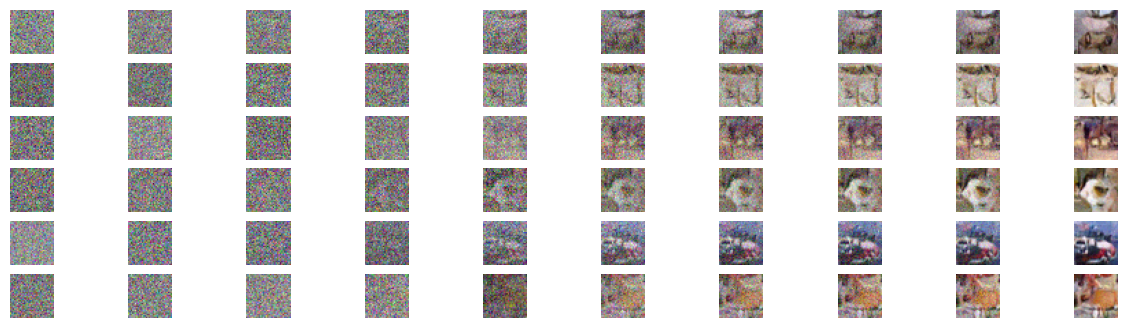

In [ ]:
import matplotlib.pyplot as plt
_ = plot_image_evolution(
    images=synthetic_images_t,
    n_images=n_images,
    n_intermediate_steps=[0, 100, 200, 300, 400, 450, 470, 480, 490, 500],
    figsize=(15, 4),
)